In [1]:
import nilearn
import sklearn
from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img,math_img,index_img,concat_imgs
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.input_data import NiftiMasker

from sklearn.model_selection import KFold
from nilearn.decoding import Decoder 
from sklearn import svm
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score

import time

import numpy as np
import pandas as pd
import os


C:\ProgramData\Anaconda3\lib\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# Set variables
ROOT_DATA='/Users/home/Documents/BIDS/'
#ROOT_DATA='/home/brunomiguel/Documents/data/BIDS/'
SUB='sub-0001'
SES='ses-001'
TASK='innerspeech'
RUN=['run-01','run-02','run-03']

# project folder
ROOT_PROJECT="/Volumes/LANGLYBACKU/MVPA_Speech_project"



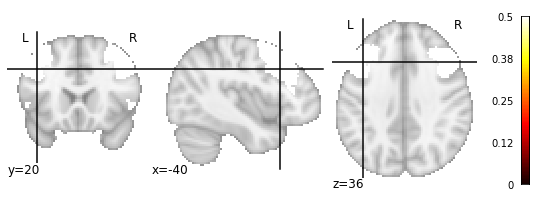

In [3]:
# mask selection
dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
atlas_filename = dataset.maps

area_idx=[47,48]
area_idx=[4,5]
mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in area_idx])
plotting.plot_stat_map(mask)

masker=NiftiMasker(mask_img=mask, standardize=True)

In [4]:
dataset

{'maps': 'C:\\Users\\bdireito/nilearn_data\\fsl\\data\\atlases\\HarvardOxford\\HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
 'labels': ['Background',
  'Frontal Pole',
  'Insular Cortex',
  'Superior Frontal Gyrus',
  'Middle Frontal Gyrus',
  'Inferior Frontal Gyrus, pars triangularis',
  'Inferior Frontal Gyrus, pars opercularis',
  'Precentral Gyrus',
  'Temporal Pole',
  'Superior Temporal Gyrus, anterior division',
  'Superior Temporal Gyrus, posterior division',
  'Middle Temporal Gyrus, anterior division',
  'Middle Temporal Gyrus, posterior division',
  'Middle Temporal Gyrus, temporooccipital part',
  'Inferior Temporal Gyrus, anterior division',
  'Inferior Temporal Gyrus, posterior division',
  'Inferior Temporal Gyrus, temporooccipital part',
  'Postcentral Gyrus',
  'Superior Parietal Lobule',
  'Supramarginal Gyrus, anterior division',
  'Supramarginal Gyrus, posterior division',
  'Angular Gyrus',
  'Lateral Occipital Cortex, superior division',
  'Lateral Occipital Cor

In [5]:
bs_maps=None
classification_target=None

for r in RUN:
    
    # Load data
    bs_fn=os.path.join(SUB + '_' + SES + '_task-' + TASK + '_'+ r +'_bold_bs.nii.gz')
    bs_map= image.load_img(bs_fn)
    
    
    # Mask data
    # masker=NiftiMasker(mask_img=mask, standardize=True)
    # mask_timecourse=masker.fit_transform(bs_maps)
    
    # Load labels
    labels_fn=os.path.join(SUB + '_' + SES + '_task-' + TASK + '_'+ r +'_labels.csv')
    col_list = ["0"]
    labels=pd.read_csv(labels_fn, usecols=col_list)
    
    
    if bs_maps is None:
        bs_maps=bs_map
        classification_target=labels
    else:
        bs_maps=[bs_maps,bs_map]
        classification_target=np.vstack((classification_target, labels))
    
    del bs_map,labels


In [6]:
bs_maps=concat_imgs(bs_maps, auto_resample=True)
print(bs_maps.shape)

(91, 109, 91, 756)


In [7]:
target_tags=['Baseline', 'Syllables', 'Words', 'Phrases', 'Vogals']

# Then we define the various classifiers that we use
classifiers = ['svc_l1']

In [20]:
# Here we compute prediction scores and run time for all these
# classifiers
cv = 3
classifiers_data = {}
classifiers = ['svc_l1']

for classifier_name in classifiers:
    print(70 * '_')
   
    decoder = Decoder(estimator=classifier_name,mask=masker,
                      standardize=True, cv=cv, scoring='accuracy')
    
    t0 = time.time()
    decoder.fit(bs_maps, classification_target)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for target_tag in target_tags:
        print("    %14s vs all -- ACC: %1.2f +- %1.2f" % (
            target_tag,
            np.mean(classifiers_data[classifier_name]['score'][target_tag]),
            np.std(classifiers_data[classifier_name]['score'][target_tag]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores
    
 

______________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


    svc_l1: 54.41s
          Baseline vs all -- ACC: 0.71 +- 0.00
         Syllables vs all -- ACC: 0.81 +- 0.01
             Words vs all -- ACC: 0.81 +- 0.02
           Phrases vs all -- ACC: 0.78 +- 0.03
            Vogals vs all -- ACC: 0.79 +- 0.05


In [21]:
decoder.cv_scores_

{'Baseline': [0.7142857142857143, 0.7142857142857143, 0.7142857142857143],
 'Phrases': [0.7777777777777778, 0.746031746031746, 0.8214285714285714],
 'Syllables': [0.7936507936507936, 0.8214285714285714, 0.8214285714285714],
 'Vogals': [0.8214285714285714, 0.7182539682539683, 0.8373015873015873],
 'Words': [0.7857142857142857, 0.8174603174603174, 0.8214285714285714],
 'AVERAGE': array([0.77857143, 0.76349206, 0.8031746 ])}

In [9]:
with open('area_comparison.txt', 'a+') as f:
    print(area_idx,file=f)
    print(classifiers_data,file=f)

## Comparison with Dummy predictor

In [10]:
from sklearn.dummy import DummyClassifier
# Here we compute prediction scores and run time for all these
# classifiers
import time

cv = 5
classifiers_data = {}
classifiers=['dummy']

for classifier_name in classifiers:
    print(70 * '_')

    # The decoder has as default score the `roc_auc`
    decoder = Decoder(estimator=DummyClassifier(strategy='stratified'),mask=masker,cv=cv,
                      standardize=True, scoring='accuracy')
 
    t0 = time.time()
    decoder.fit(bs_maps, classification_target)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for target_tag in target_tags:
        print("    %14s vs all -- ACC: %1.2f +- %1.2f" % (
            target_tag,
            np.mean(classifiers_data[classifier_name]['score'][target_tag]),
            np.std(classifiers_data[classifier_name]['score'][target_tag]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores
    

______________________________________________________________________


C:\ProgramData\Anaconda3\lib\site-packages\nilearn\decoding\decoder.py:143: UserWarning: Use a custom estimator at your own risk of the process not working as intended.
  warnings.warn('Use a custom estimator at your own risk '


     dummy: 29.61s
          Baseline vs all -- ACC: 0.60 +- 0.03
         Syllables vs all -- ACC: 0.70 +- 0.02
             Words vs all -- ACC: 0.69 +- 0.01
           Phrases vs all -- ACC: 0.71 +- 0.04
            Vogals vs all -- ACC: 0.72 +- 0.01


In [ ]:
mask_timecourse=masker.fit_transform(bs_maps)
null_cv_scores = cross_val_score(
    DummyClassifier(strategy='prior'),mask_timecourse, classification_target, scoring='accuracy')
print(null_cv_scores)

In [ ]:
dummy_clf = DummyClassifier()
dummy_clf.fit(mask_timecourse, classification_target)

dummy_clf.score(mask_timecourse, classification_target)


## Playing with other masks


In [ ]:
from nilearn.datasets import fetch_icbm152_brain_gm_mask
brain_mask = fetch_icbm152_brain_gm_mask()


# Then we define the various classifiers that we use
classifiers = ['svc_l1','logistic_l1']


# Here we compute prediction scores and run time for all these
# classifiers
import time

cv = 5
classifiers_data = {}

for classifier_name in classifiers:
    print(70 * '_')

    # The decoder has as default score the `roc_auc`
    decoder = Decoder(estimator=classifier_name,mask=brain_mask,
                      standardize=True, cv=cv, scoring='accuracy')
    t0 = time.time()
    decoder.fit(bs_maps, classification_target)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for target_tag in target_tags:
        print("    %14s vs all -- AUC: %1.2f +- %1.2f" % (
            target_tag,
            np.mean(classifiers_data[classifier_name]['score'][target_tag]),
            np.std(classifiers_data[classifier_name]['score'][target_tag]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores